In [1]:
# load modules
import os
import numpy as np
import pandas as pd
import pickle

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt

import palantir
import scanpy as sc

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline

## Download data

Anndata objects with all the data and metadata are publically avaiable at: https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep[1-3].h5ad. This notebook use replicate 1 (https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep1.h5ad) for illustration. 

Description of the anndata object is available at https://s3.amazonaws.com/dp-lab-data-public/palantir/readme

## Load data

In [4]:
# Load the AnnData object
load_ad = sc.read('annadata/human_cd34_bm_rep1.h5ad')
colors = pd.Series(load_ad.uns['cluster_colors'])
ct_colors = pd.Series(load_ad.uns['ct_colors'])

## PAGA

In [5]:
# Start from the counts
ad = sc.AnnData(load_ad.raw.X)
ad.obs_names = load_ad.obs_names
ad.var_names = load_ad.var_names

In [6]:
# Preprocess
sc.pp.recipe_zheng17(ad, log=True)
sc.tl.pca(ad)
sc.pp.neighbors(ad, n_neighbors=60)
sc.tl.draw_graph(ad)
sc.tl.louvain(ad, resolution=1.2)

running recipe zheng17
filtered out 27 genes that are detected in less than 1 counts
    normalizing by total count per cell
        finished (0:00:00.24): normalized adata.X and added
        'n_counts_all', counts per cell before normalization (adata.obs)
    extracting highly variable genes
    the 1000 top genes correspond to a normalized dispersion cutoff of
        finished (0:00:00.95)
    normalizing by total count per cell
        finished (0:00:00.02): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)
    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:00.02)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00.16)
    and ad

## Graph abstraction

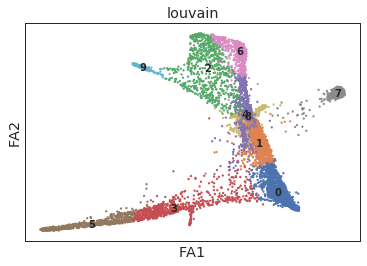

In [7]:
ax = sc.pl.draw_graph(ad, color=['louvain'], legend_loc='on data')

In [8]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)/255 for i in range(0, lv, lv // 3))


In [9]:
# Palantir colors for comparison
ad.uns['louvain_colors'][0] = hex_to_rgb(colors[0])
ad.uns['louvain_colors'][3] = hex_to_rgb(colors[2])
ad.uns['louvain_colors'][5] = hex_to_rgb(colors[8])
ad.uns['louvain_colors'][7] = hex_to_rgb(colors[5])
ad.uns['louvain_colors'][1] = hex_to_rgb(colors[1])
ad.uns['louvain_colors'][4] = hex_to_rgb(colors[4])
ad.uns['louvain_colors'][6] = hex_to_rgb(colors[3])
ad.uns['louvain_colors'][9] = hex_to_rgb(colors[7])

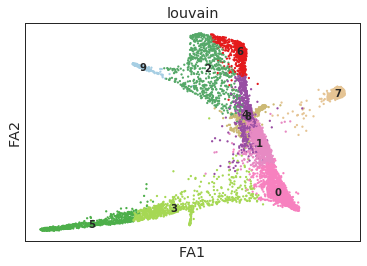

In [10]:
ax = sc.pl.draw_graph(ad, color=['louvain'], legend_loc='on data')

In [11]:
sc.tl.paga(ad, groups='louvain')

running PAGA
        initialized `.distances` `.connectivities` 
    finished (0:00:00.46) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


### Trends 

In [12]:
ad.uns['iroot'] = np.flatnonzero(ad.obs_names == load_ad.obs['palantir_pseudotime'].idxmin())[0]

In [13]:
sc.tl.dpt(ad)

computing Diffusion Maps using n_comps=15(=n_dcs)
        initialized `.distances` `.connectivities` 
    computed transitions (0:00:00.04)
    eigenvalues of transition matrix
    [1.         0.9932567  0.9862846  0.98253083 0.9780972  0.9741326
     0.9676509  0.9581074  0.9569015  0.9373291  0.93159527 0.92538345
     0.9032845  0.8965749  0.89336187]
    finished (0:00:00.25) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


In [14]:
ad_raw = sc.AnnData(load_ad.raw.X)
ad_raw.obs_names = load_ad.obs_names
ad_raw.var_names = load_ad.var_names

# Normalize the data here since raw gets used for trend estimation
sc.pp.log1p(ad_raw)
sc.pp.scale(ad_raw)

ad.raw = ad_raw

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [15]:
genes = ['CD34', 'MPO', 'IRF8', 'CD79A', 'GATA1', 'ITGA2B'] + \
    ['CD34', 'SPI1', 'MPO', 'GATA1', 'IRF8', 'CD79B', 'RAG1', 'CEBPG', 'CSF1R']
genes = list(set(genes))

In [16]:
trends = pd.Series()

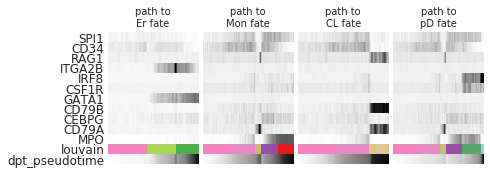

In [17]:
paths = [('Ery', [0, 3, 5]),  # use the category indices instead of the cluster names
         ('Mono', [0, 1, 8, 4, 6]), 
         ('CLP', [0, 1, 7]),
         ('pDC', [0, 1, 8, 4, 2, 9])]

_, axs = plt.subplots(ncols=len(paths), figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.11})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        ad, path, genes,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',                             
        title='path to\n{} fate'.format(descr[:-1]),
        return_data=True,
        show=False)
    trends[descr] = data

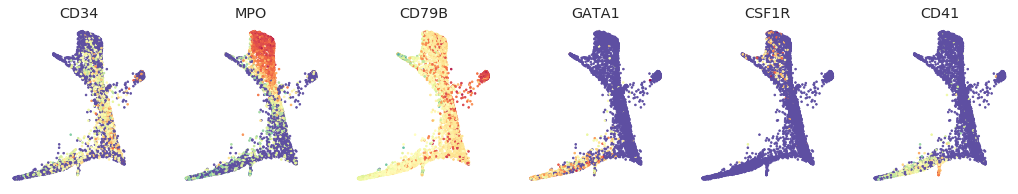

In [18]:
genes = ['CD34', 'MPO', 'CD79B', 'GATA1', 'CSF1R', 'ITGA2B']
labels = ['CD34', 'MPO', 'CD79B', 'GATA1', 'CSF1R', 'CD41']

fig = palantir.plot.FigureGrid(6, 6)
layout = ad.obsm['X_draw_graph_fa']
for gene, label, ax in zip(genes, labels, fig):
    ax.scatter(layout[:, 0], layout[:, 1], s=3,
              c=load_ad[:, gene].X, cmap=matplotlib.cm.Spectral_r)
    ax.set_axis_off()
    ax.set_title(label)


In [19]:
from matplotlib.ticker import FormatStrFormatter

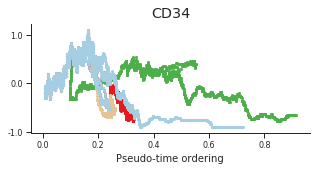

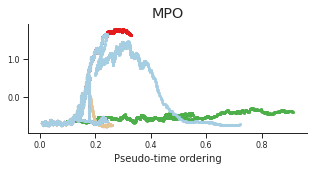

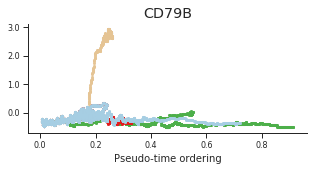

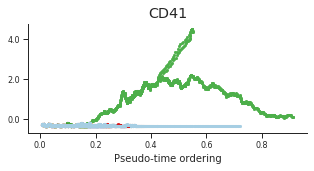

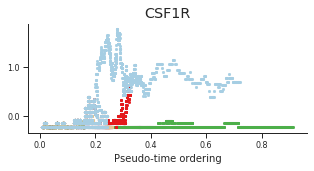

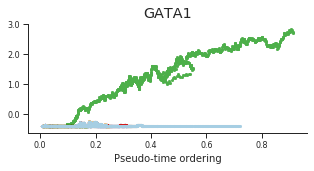

In [20]:
genes = ['CD34', 'MPO',  'CD79B', 'ITGA2B', 'CSF1R', 'GATA1']
labels = ['CD34', 'MPO', 'CD79B', 'CD41', 'CSF1R', 'GATA1']

for gene, label in zip(genes, labels):
    fig = plt.figure(figsize=[5, 2])

    ax = plt.gca()

    for l in trends.keys():
        order = trends[l].distance.sort_values().index
    
        bins = np.ravel(trends[l].distance[order])
        t = np.ravel(trends[l].loc[order, gene])

        # Plot
        plt.scatter(bins, t, color=ct_colors[l], s=5)


    ax.set_title(label)
    ax.set_xlabel('Pseudo-time ordering', fontsize=10)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    